# Housekeeping

In [157]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint
import matplotlib.dates as mdates
timespan = 365


# Data Gathering

In [158]:
def get_data():
    BRENT = yf.download("BZ=F", auto_adjust=True, period='max')["Close"]
    WTI = yf.download("CL=F", auto_adjust=True, period='max')["Close"]

    df = pd.concat([BRENT, WTI], axis=1)
    df.columns = ['BRENT', 'WTI']
    df = df.iloc[-timespan:]
    return df.dropna()

def plot_price_data(df):
    
    plt.figure(figsize=(12, 7))
    plt.plot(df['BRENT'], label='BRENT Close', color='darkorange', linewidth=2)
    plt.plot(df['WTI'], label='WTI Close', color='mediumblue', linewidth=2)
    plt.title('BRENT vs WTI Close Prices', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price (USD)', fontsize=14)
    plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    return df


# Checking Probability and Suitability for Modelling

In [159]:
def check_suitability(series1, series2, corr_thresh=0.8, coint_p_thresh=0.05):
    correlation = series1.corr(series2)
    print(f"Pearson correlation (for reference): {correlation:.4f}")

    score, pvalue, _ = coint(series1, series2)
    print(f"Engle-Granger cointegration p-value: {pvalue:.4f}")

    if pvalue >= coint_p_thresh:
        print(f"→ Not cointegrated (p ≥ {coint_p_thresh}). Skip strategy.")
        return False
    print("Pair is cointegrated. Suitable for pairs trading.")
    return True

# Calculating Spread and Optimal Zscore

In [160]:
def optimise_zscore(df):
    entry_values = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2]
    exit_values = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2]

    results = []

    for entry_z in entry_values:
        for exit_z in exit_values:
            if exit_z >= entry_z:
                continue
            ret, sharpe, dd = run_strategy(df, entry_z, exit_z)
            results.append({
                'entry_z': entry_z,
                'exit_z': exit_z,
                'return': ret,
                'sharpe': sharpe,
                'drawdown': dd
            })

    results_df = pd.DataFrame(results)
    best = results_df.loc[results_df['sharpe'].idxmax()]
    
    print(results_df.sort_values(by='sharpe', ascending=False))
    print(f"The optimal strategy uses an entry z-score threshold of {best['entry_z']} and an exit z-score threshold of {best['exit_z']}.")

    # Sharpe Heatmap
    plt.figure(figsize=(8, 8))
    pivot_sharpe = results_df.pivot(index='exit_z', columns='entry_z', values='sharpe')
    sns.heatmap(pivot_sharpe, annot=True, fmt=".2f", cmap='RdYlGn')
    plt.title("Sharpe Ratio by Entry/Exit Z-Thresholds")
    plt.xlabel("Entry Z-Score")
    plt.ylabel("Exit Z-Score")
    plt.show()

    return best['entry_z'], best['exit_z']



def calculate_spread_zscore(df, entry_z=None, exit_z=None, plot=False):
    df['spread'] = df['BRENT'] - df['WTI']
    df['spread_mean'] = df['spread'].rolling(window=30).mean()
    df['spread_std'] = df['spread'].rolling(window=30).std()
    df['spread_zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']

    if plot:
        plt.figure(figsize=(12, 7))
        plt.plot(df['spread'], label='BRENT-WTI Spread', color='mediumblue', linewidth=2)
        plt.plot(df['spread_mean'], label='30-Day Moving Average', color='orange', linewidth=2, linestyle='--')

        plt.title('BRENT-WTI Spread and 30-Day Moving Average', fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Spread ($)', fontsize=14)

        plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True)
        plt.grid(True, linestyle='--', alpha=0.5)

        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 7))
        plt.plot(df['spread_zscore'], label='Spread Z-Score', color='mediumblue', linewidth=2)

        entry_line = entry_z if entry_z is not None else 1
        exit_line = exit_z if exit_z is not None else 0.5

 
        plt.axhline(entry_z, color='darkred', linestyle='--', linewidth=2, label='Entry Short (Short Brent, Long WTI)')
        plt.axhline(-entry_z, color='darkgreen', linestyle='--', linewidth=2, label='Entry Long (Long Brent, Short WTI)')

        plt.axhline(exit_z, color='red', linestyle='-.', linewidth=2, alpha=1, label='Exit Short (Close Short)')
        plt.axhline(-exit_z, color='green', linestyle='-.', linewidth=2, alpha=1, label='Exit Long (Close Long)')

        plt.title('Spread Z-Score with Trading Signal Thresholds', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Z-Score', fontsize=14)
        plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    return df


# Generating Buy/Sell Signals & Calculating Returns

In [175]:

#Buy and Sell Signals

def define_signals(df, entry_z, exit_z):
    df['position'] = 0
    df.loc[df['spread_zscore'] > entry_z, 'position'] = -1
    df.loc[df['spread_zscore'] < -entry_z, 'position'] = 1
    df.loc[(df['spread_zscore'] > -exit_z) & (df['spread_zscore'] < exit_z), 'position'] = 0
    return df

def explicit_positions(df):
    df['BRENT_position'] = 0
    df['WTI_position'] = 0
    df.loc[df['position'] == 1, ['BRENT_position', 'WTI_position']] = [1, -1]
    df.loc[df['position'] == -1, ['BRENT_position', 'WTI_position']] = [-1, 1]
    return df

def calculate_returns(df):
    df['BRENT_returns'] = df['BRENT'].pct_change()
    df['WTI_returns'] = df['WTI'].pct_change()

    df['strategy_returns_explicit'] = (
        df['BRENT_position'].shift(1) * df['BRENT_returns'] +
        df['WTI_position'].shift(1) * df['WTI_returns']
    )

    # Calculate cumulative returns for Brent, WTI, and the strategy
    df['BRENT_cumulative'] = (1 + df['BRENT_returns'].fillna(0)).cumprod()
    df['WTI_cumulative'] = (1 + df['WTI_returns'].fillna(0)).cumprod()
    df['strategy_cumulative_explicit'] = (1 + df['strategy_returns_explicit'].fillna(0)).cumprod()

    plt.figure(figsize=(12, 7))
    plt.plot(df['strategy_cumulative_explicit'], label='Strategy Cumulative Return', color='mediumblue', linewidth=2)
    plt.plot(df['BRENT_cumulative'], label='Brent Cumulative Return', color='orange', linewidth=2, alpha=0.8)
    plt.plot(df['WTI_cumulative'], label='WTI Cumulative Return', color='green', linewidth=2, alpha=0.8)
    
    plt.title('Cumulative Returns: Strategy vs Brent and WTI', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Cumulative Return', fontsize=14)
    plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return df
    

# Strategy Execution and Performance Metrics

In [176]:
def performance_summary(df):
    BRENT_Return = (df['BRENT_returns'].dropna() + 1).prod() - 1
    WTI_Return = (df['WTI_returns'].dropna() + 1).prod() - 1

    pnl_pct = (df['strategy_cumulative_explicit'].iloc[-1] - 1) * 100
    mean_ret = df['strategy_returns_explicit'].mean()
    std_ret = df['strategy_returns_explicit'].std()

    print(f"BRENT WTI Arbitrage Strategy P&L: {pnl_pct:.2f}%")
    print(f"BRENT Price Change: {BRENT_Return * 100:.2f}%")
    print(f"WTI Price Change: {WTI_Return * 100:.2f}%")

def run_strategy(df, entry_z=1.0, exit_z=0.5):
    df = df.copy()
    df['position'] = 0
    df.loc[df['spread_zscore'] > entry_z, 'position'] = -1
    df.loc[df['spread_zscore'] < -entry_z, 'position'] = 1
    df.loc[(df['spread_zscore'] > -exit_z) & (df['spread_zscore'] < exit_z), 'position'] = 0

    df['BRENT_position'] = 0
    df['WTI_position'] = 0
    df.loc[df['position'] == 1, ['BRENT_position', 'WTI_position']] = [1, -1]
    df.loc[df['position'] == -1, ['BRENT_position', 'WTI_position']] = [-1, 1]

    df['BRENT_returns'] = df['BRENT'].pct_change()
    df['WTI_returns'] = df['WTI'].pct_change()

    df['strategy_returns'] = (
        df['BRENT_position'].shift(1) * df['BRENT_returns'] +
        df['WTI_position'].shift(1) * df['WTI_returns']
    )

    df['cumulative'] = (1 + df['strategy_returns'].fillna(0)).cumprod()

    total_return = df['cumulative'].iloc[-1] - 1
    sharpe = df['strategy_returns'].mean() / df['strategy_returns'].std() * np.sqrt(252)
    drawdown = (df['cumulative'] / df['cumulative'].cummax() - 1).min()

    return total_return, sharpe, drawdown






# Running the Code

In [177]:
def main():
    df = get_data()
    plot_price_data(df)

    if not check_suitability(df['BRENT'], df['WTI']):
        print("Aborting: unsuitable pair.")
        return None

    # Calculate z-score once without plotting (needed for optimization)
    df = calculate_spread_zscore(df, plot=False)

    # Find optimal entry and exit z-score thresholds using the spread_zscore in df
    entry_z_opt, exit_z_opt = optimise_zscore(df)

    print(f"Optimal entry z-score: {entry_z_opt}, exit z-score: {exit_z_opt}")

    # Recalculate and plot z-score with optimal thresholds (only now plot)
    df = calculate_spread_zscore(df, entry_z=entry_z_opt, exit_z=exit_z_opt, plot=True)

    # Define signals and proceed
    df = define_signals(df, entry_z_opt, exit_z_opt)
    df = explicit_positions(df)
    df = calculate_returns(df)
    performance_summary(df)

    return df



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


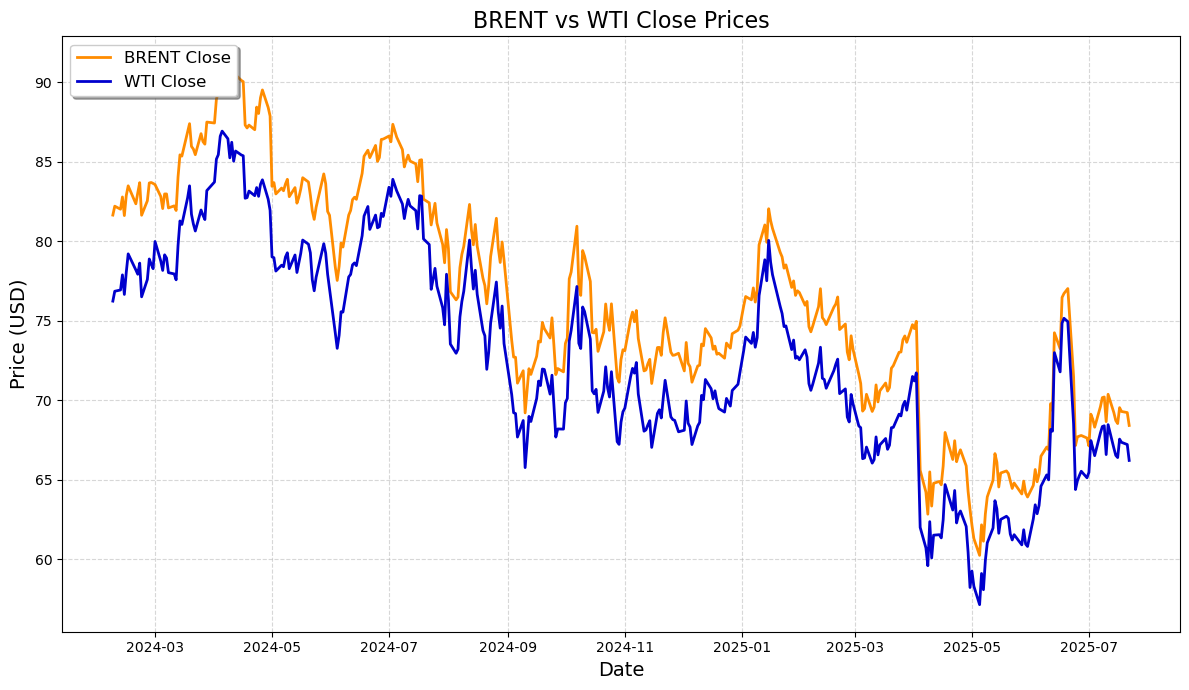

Pearson correlation (for reference): 0.9943
Engle-Granger cointegration p-value: 0.0008
Pair is cointegrated. Suitable for pairs trading.
    entry_z  exit_z    return    sharpe  drawdown
3      1.00    0.25  0.229801  2.502231 -0.017730
4      1.00    0.50  0.229801  2.502231 -0.017730
5      1.00    0.75  0.229801  2.502231 -0.017730
14     1.50    1.25  0.178192  2.266602 -0.017730
10     1.50    0.25  0.178192  2.266602 -0.017730
13     1.50    1.00  0.178192  2.266602 -0.017730
12     1.50    0.75  0.178192  2.266602 -0.017730
11     1.50    0.50  0.178192  2.266602 -0.017730
8      1.25    0.75  0.192348  2.254853 -0.017730
9      1.25    1.00  0.192348  2.254853 -0.017730
7      1.25    0.50  0.192348  2.254853 -0.017730
6      1.25    0.25  0.192348  2.254853 -0.017730
15     1.75    0.25  0.158593  2.160059 -0.012380
16     1.75    0.50  0.158593  2.160059 -0.012380
17     1.75    0.75  0.158593  2.160059 -0.012380
18     1.75    1.00  0.158593  2.160059 -0.012380
19     1.75 

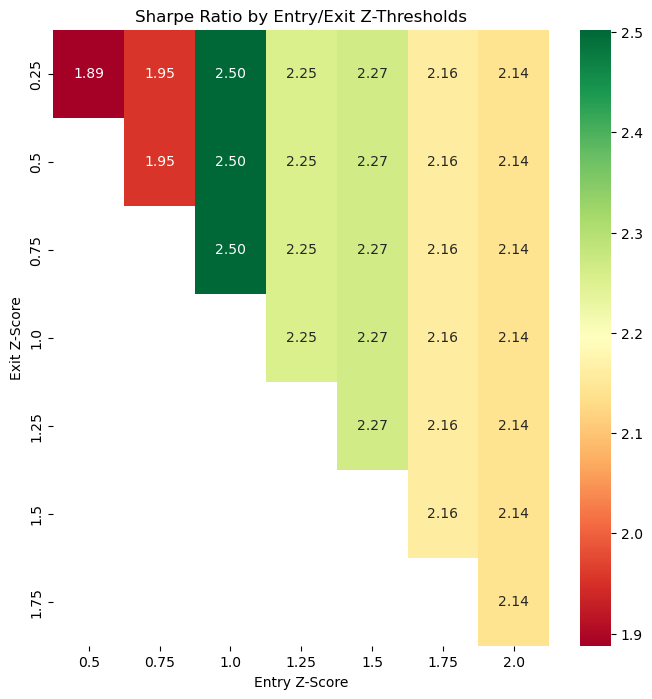

Optimal entry z-score: 1.0, exit z-score: 0.25


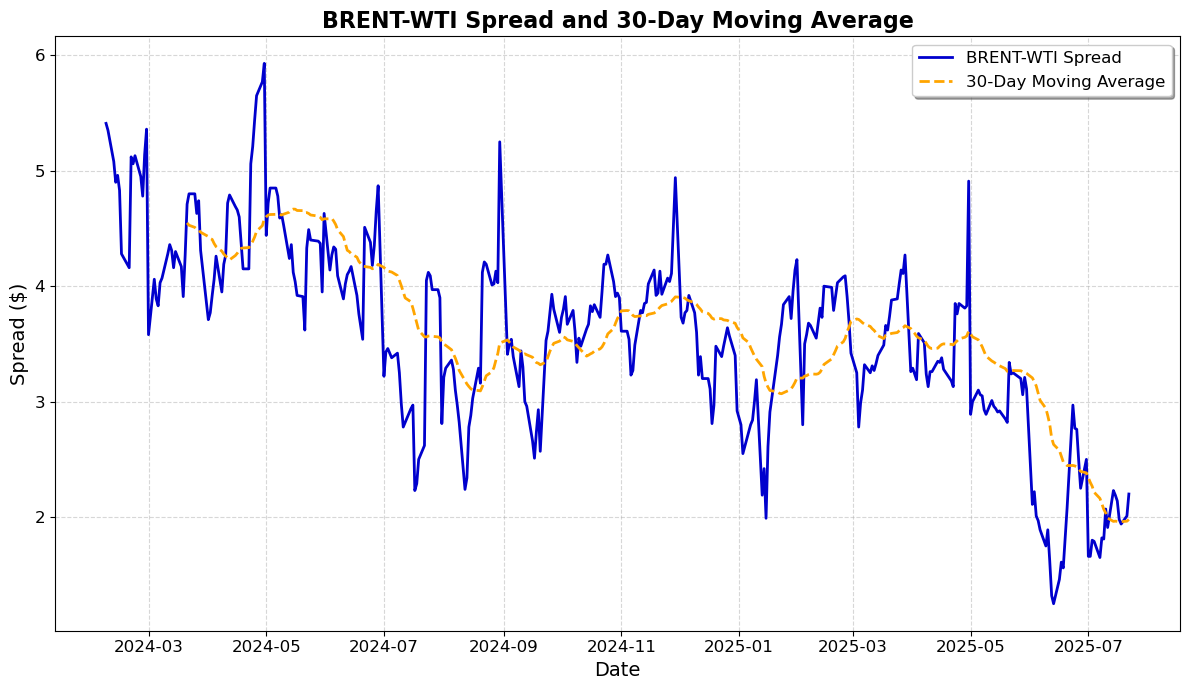

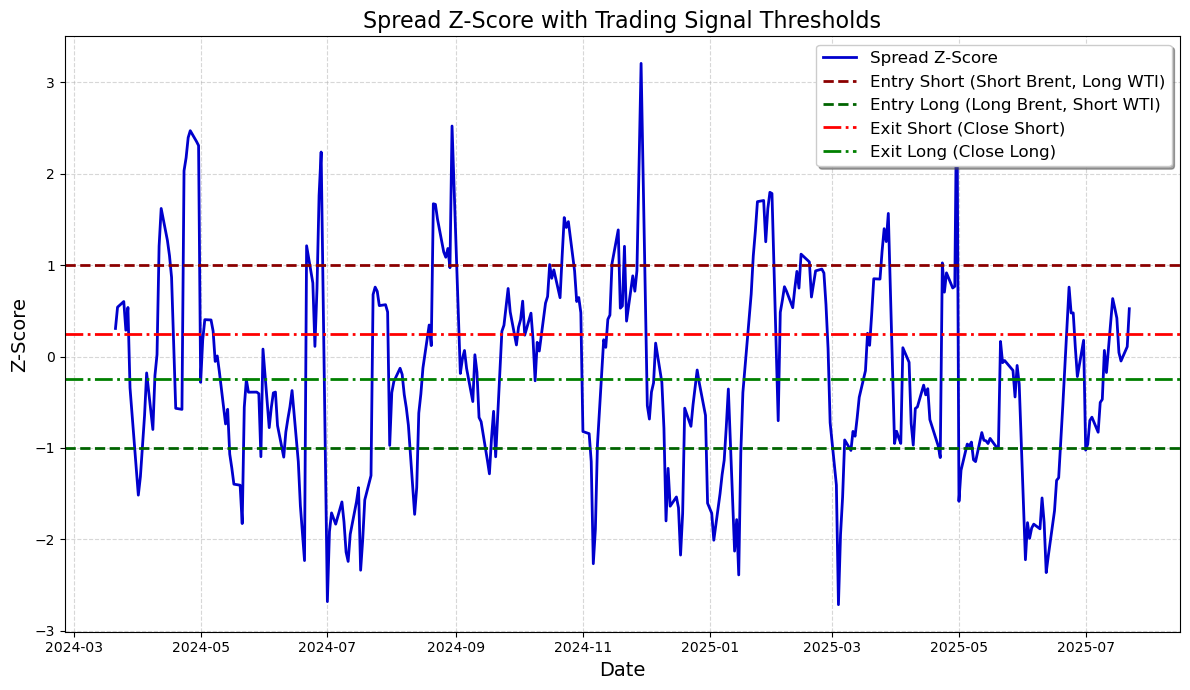

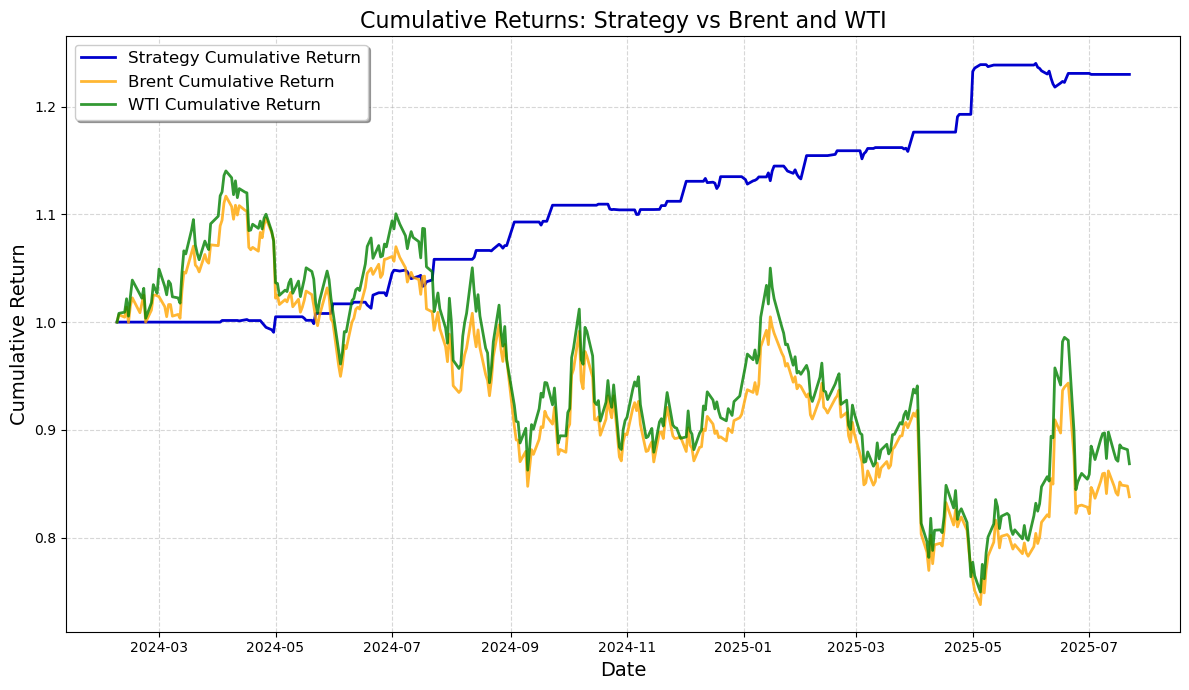

BRENT WTI Arbitrage Strategy P&L: 22.98%
BRENT Price Change: -16.21%
WTI Price Change: -13.15%


,BRENT,WTI,spread,spread_mean,spread_std,spread_zscore,position,BRENT_position,WTI_position,BRENT_returns,WTI_returns,strategy_returns_explicit,BRENT_cumulative,WTI_cumulative,strategy_cumulative_explicit
Date,,,,,,,,,,,,,,,
2024-02-08,81.629997,76.220001,5.409996,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,1.000000,1.000000,1.000000
2024-02-09,82.190002,76.839996,5.350006,NaN,NaN,NaN,0,0,0,0.006860,0.008134,0.0,1.006860,1.008134,1.000000
2024-02-12,82.000000,76.919998,5.080002,NaN,NaN,NaN,0,0,0,-0.002312,0.001041,0.0,1.004533,1.009184,1.000000
2024-02-13,82.769997,77.870003,4.899994,NaN,NaN,NaN,0,0,0,0.009390,0.012351,0.0,1.013965,1.021648,1.000000
2024-02-14,81.599998,76.639999,4.959999,NaN,NaN,NaN,0,0,0,-0.014136,-0.015796,-0.0,0.999633,1.005510,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-16,68.519997,66.379997,2.139999,1.962667,0.421442,0.420774,0,0,0,-0.002765,-0.002105,-0.0,0.839397,0.870900,1.229801
2025-07-17,69.519997,67.540001,1.979996,1.961667,0.421361,0.043498,0,0,0,0.014594,0.017475,0.0,0.851648,0.886119,1.229801
2025-07-18,69.279999,67.339996,1.940002,1.960667,0.421376,-0.049042,0,0,0,-0.003452,-0.002961,-0.0,0.848708,0.883495,1.229801


In [178]:
main()